# Variational Autoencoder on MNIST Dataset

<img src="variational_autoencoder_model.png" width="800px" style="float:center">

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.initializers import RandomNormal
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


## Utilities

In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    
    cmap = plt.get_cmap('RdBu', np.max(y_test)-np.min(y_test)+1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap=cmap, vmin = np.min(y_test)-.5, vmax = np.max(y_test)+.5)
    plt.colorbar(ticks=np.arange(np.min(y_test),np.max(y_test)+1))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "latent_manifold.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

## Load dataset

In [3]:
# load the dataset without labels

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape images
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
layer_1_dim = 1000
layer_2_dim = 1000
batch_size = 100
latent_dim = 2
epochs = 100

kernel_initializer =  RandomNormal(mean=0.0, stddev=0.01, seed=None)
bias_initializer= RandomNormal(mean=0.0, stddev=0.01, seed=None)

kernel_initializer='glorot_uniform'
bias_initializer='zeros'

## Build the variational autoencoder model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 784)          0                                            
__________________________________________________________________________________________________
H1 (Dense)                      (None, 1000)         785000      X[0][0]                          
__________________________________________________________________________________________________
H2 (Dense)                      (None, 1000)         1001000     H1[0][0]                         
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            2002        H2[0][0]                         
_____________________________________

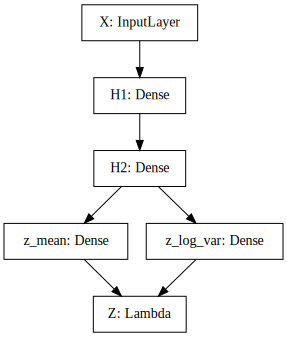

In [4]:
# VAE model = encoder + decoder

# build encoder model
input_encoder = Input(shape=input_shape, name='X')
x = Dense(layer_1_dim, activation='relu', name='H1', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(input_encoder)
x = Dense(layer_2_dim, activation='relu', name='H2', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
z_mean = Dense(latent_dim, name='z_mean', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
z_log_var = Dense(latent_dim, name='z_log_var', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='Z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(input_encoder, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='img/vae_encoder_mnist.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 2)                 0         
_________________________________________________________________
H1 (Dense)                   (None, 1000)              3000      
_________________________________________________________________
H2 (Dense)                   (None, 1000)              1001000   
_________________________________________________________________
Xp (Dense)                   (None, 784)               784784    
Total params: 1,788,784
Trainable params: 1,788,784
Non-trainable params: 0
_________________________________________________________________


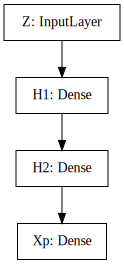

In [5]:
# build decoder model
decoder_input = Input(shape=(latent_dim,), name='Z')
x = Dense(layer_1_dim, activation='relu', name='H1', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(decoder_input)
x = Dense(layer_2_dim, activation='relu', name='H2', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(x)
x = Dense(original_dim, activation='sigmoid', name='Xp')(x)

# instantiate decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()
plot_model(decoder, to_file='img/vae_decoder_mnist.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 1790004   
_________________________________________________________________
decoder (Model)              (None, 784)               1788784   
Total params: 3,578,788
Trainable params: 3,578,788
Non-trainable params: 0
_________________________________________________________________


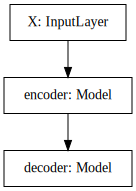

In [34]:
# instantiate VAE model
outputs = decoder(encoder(input_encoder)[2])
vae = Model(input_encoder, outputs, name='vae')
vae.summary()
plot_model(decoder, to_file='img/vae_autoencoder_mnist.png', show_shapes=True)
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

## Train the autoencoder

Let's visualize the results of a model during training using the TensorFlow backend and the TensorBoard callback.

!tensorboard --logdir=/tmp/autoencoder

open [tensorboard](http://job-ffcce10f-5ff8-4856-86c4-2ec27f650395-hk4r4:6006)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 1790004   
_________________________________________________________________
decoder (Model)              (None, 784)               1788784   
Total params: 3,578,788
Trainable params: 3,578,788
Non-trainable params: 0
_________________________________________________________________


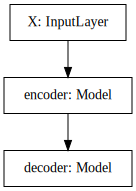

In [26]:
# let's compile the model

# expected negative log-likelihood of the ii-th datapoint (reconstruction loss)
reconstruction_loss = mse(input_encoder, outputs)
#reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

# add regularizer: Kullback-Leibler divergence between the encoder’s distribution Q(z|x) and p(z)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=['accuracy'])

vae.summary()
plot_model(vae, to_file='img/vae_mnist.png', show_shapes=True)
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [27]:
# let's train the model
vae_history = vae.fit(x_train, 
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, None),
                      callbacks=[TensorBoard(log_dir='/tmp/vae')],
                      verbose=1)

vae.save_weights('models/vae_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 13s 218us/step - loss: 37.9614 - val_loss: 37.6249
Epoch 2/100
60000/60000 [==============================] - 11s 186us/step - loss: 37.2440 - val_loss: 37.0465
Epoch 3/100
60000/60000 [==============================] - 11s 190us/step - loss: 36.8011 - val_loss: 36.7176
Epoch 4/100
60000/60000 [==============================] - 12s 205us/step - loss: 36.3710 - val_loss: 36.4487
Epoch 5/100
60000/60000 [==============================] - 11s 189us/step - loss: 36.1217 - val_loss: 36.1326
Epoch 6/100
60000/60000 [==============================] - 11s 185us/step - loss: 35.8583 - val_loss: 35.8558
Epoch 7/100
60000/60000 [==============================] - 11s 183us/step - loss: 35.6047 - val_loss: 35.7113
Epoch 8/100
60000/60000 [==============================] - 11s 183us/step - loss: 35.4842 - val_loss: 35.6477
Epoch 9/100
60000/60000 [==============================] - 11s 186us/s

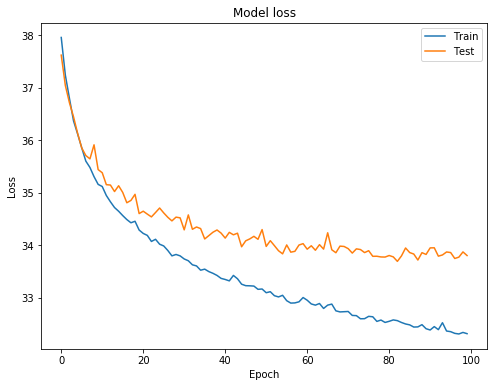

In [30]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(vae_history.history['loss'])
plt.plot(vae_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [10]:
# load the model
#vae.load_weights(args.weights)

## Visualization

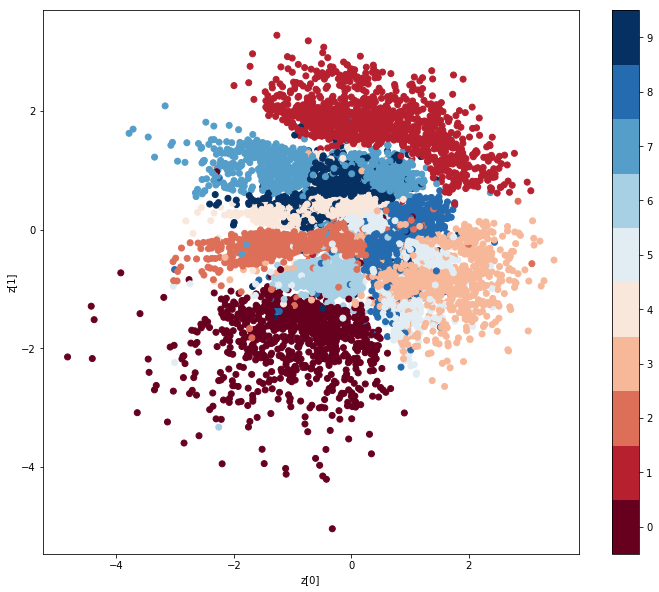

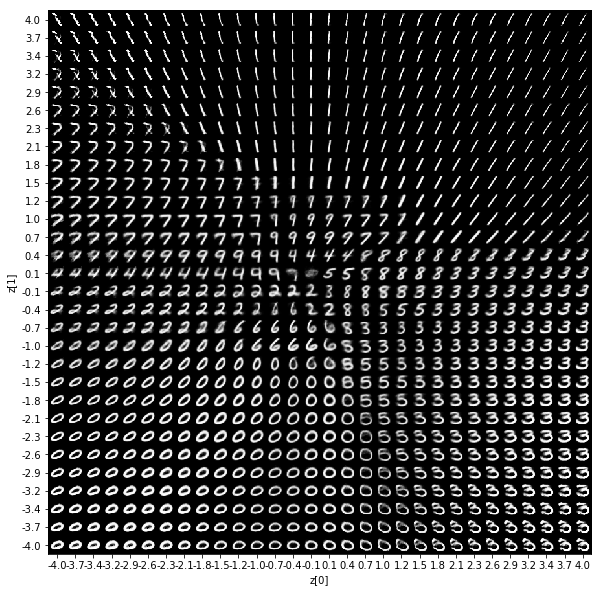

In [31]:
models = (encoder, decoder)
data = (x_test, y_test)
    
plot_results(models, data, batch_size=batch_size, model_name="vae_results")

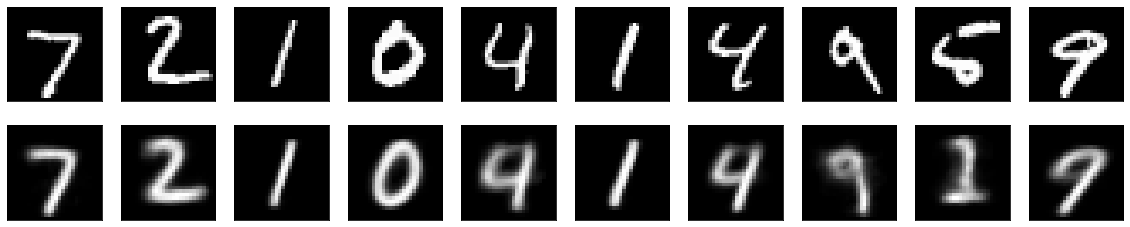

In [32]:
decoded_imgs = vae.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()